# ДЗ 2:

1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt (5 баллов)

2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt (5 баллов)
- логарфимированной метрике cart_added_cnt (5 баллов)
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (5 баллов)


В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped
(+ 5 балла за обьяснения и выводы)


3. Реализовать разбивку на бакеты любым (правильным) способом, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные) (5 баллов)
- на метрике cart_added_cnt (5 баллов)


4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) (5 баллов)
подсчитать результаты для случая без постстратификации и с постстратификацией. (дисперсию и среднее)
- проверить мощность и корректность t-критерия для постстратифицированного случая (5 баллов)


(+ 5 балла за обьяснения и выводы)

In [22]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import warnings
import os


from tqdm.auto import tqdm
from sklearn.utils import shuffle
from base64 import b64encode
from statsmodels.stats.weightstats import ztest
from scipy.stats import ttest_ind, mannwhitneyu
from joblib import Parallel, delayed

plt.style.use('ggplot')
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
shop_metrics_new = pd.read_excel('shop_df_metrics_dec.xlsx').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_excel('shop_df_metrics_sept.xlsx').drop(columns='Unnamed: 0')
shop_users_info = pd.read_excel('shop_df_users.xlsx').drop(columns='Unnamed: 0')

Метрики:
   - is_viewed - айтем товара просмотрен
   - products_viewed_cnt - количество уникальных просмотренных айтемов
   - price_sum - суммарная цена товаров
   - is_cart_added - товар добавлен в корзину
   - is_purchased - товар куплен
   - cart_added_cnt - количество товаров, добавленных в корзину
   - purchased_cnt - количество купленных товаров

In [5]:
def salt_generator(salt=None):
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')

def groups_splitter(df, user_salt=None):
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())
    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

## 1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни

In [20]:
shop = shop_metrics_new.drop(columns=['group'])

#### Исходная метрика

  0%|          | 0/1000 [00:00<?, ?it/s]

 power: 70.89999999999999%, correctness: 94.89999999999999%


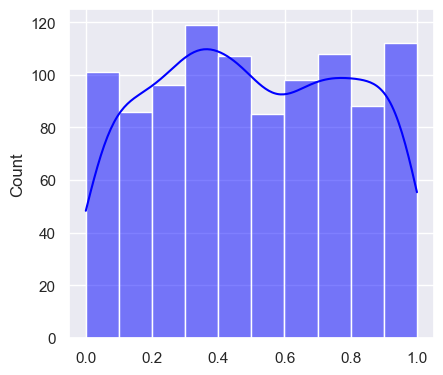

In [27]:
# t-test исходная метрики
def run_single_test():
    new_df = pd.merge(shop, groups_splitter(shop.copy(), salt_generator()), 
                     on='user_id', how='left').drop_duplicates()
    
    group_A = new_df[new_df['group']=='A']['cart_added_cnt']
    group_B = new_df[new_df['group']=='B']['cart_added_cnt'] 
    
    corr_p = ttest_ind(group_A, group_B)[1]
    power_p = ttest_ind(group_A, group_B*1.05)[1]
    
    return corr_p, power_p

results = Parallel(n_jobs=-1)(delayed(run_single_test)() for _ in tqdm(range(1000)))
correctness, power = zip(*results)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)
power_pct = (power < 0.05).mean() * 100
corr_pct = (1 - (correctness < 0.05).mean()) * 100
print(f' power: {power_pct}%, correctness: {corr_pct}%')

Результаты t-теста показывают:

- Высокая корректность (94%) - тест редко показывает ложноположительные результаты при отсутствии эффекта
- Недостаточная мощность (70%) - тест часто пропускает реальные эффекты (в 30% случаев)

#### Ранговая трансформация

In [24]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis = 0)
    df['rank'] = df[metric].rank()

    return df

ranked = rank_transformation(shop_metrics_new[shop_metrics_new.group == 'A'],
                             shop_metrics_new[shop_metrics_new.group == 'B'], 'cart_added_cnt')

  0%|          | 0/1000 [00:00<?, ?it/s]

 power: 100.0%, correctness: 95.19999999999999%


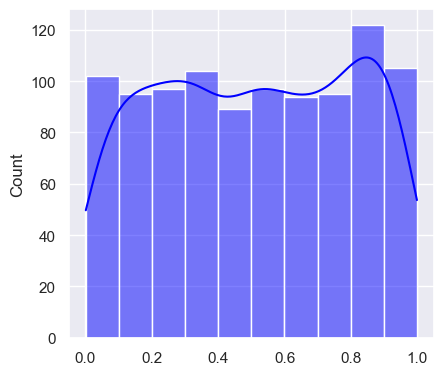

In [25]:
# t-test ранговая трансформация
def run_rank_test():
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    ranked_df = rank_transformation(new_df[new_df.group == 'A'], new_df[new_df.group == 'B'], 'cart_added_cnt')
    vec_a = ranked_df[(ranked_df['group'] == 'A')]['rank']
    vec_b = ranked_df[(ranked_df['group'] == 'B')]['rank']
    
    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.05
    new_df_b = new_df[new_df.group == 'B'].copy()
    new_df_b['cart_added_cnt'] = vec_b_effect
    
    ranked_df_effect = rank_transformation(new_df[new_df.group == 'A'], new_df_b, 'cart_added_cnt')
    vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['rank']
    vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['rank']

    p_cor = ttest_ind(vec_a, vec_b)[1]
    p_power = ttest_ind(vec_a_power, vec_b_power)[1]
    
    return p_cor, p_power

results = Parallel(n_jobs=-1)(delayed(run_rank_test)() for _ in tqdm(range(1000)))
correctness, power = zip(*results)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)
power_pct = (power < 0.05).mean() * 100
corr_pct = (1 - (correctness < 0.05).mean()) * 100

print(f' power: {power_pct}%, correctness: {corr_pct}%')

#### Манн-Уитни

  0%|          | 0/1000 [00:00<?, ?it/s]

power: 100.0%, correctness: 95.5%


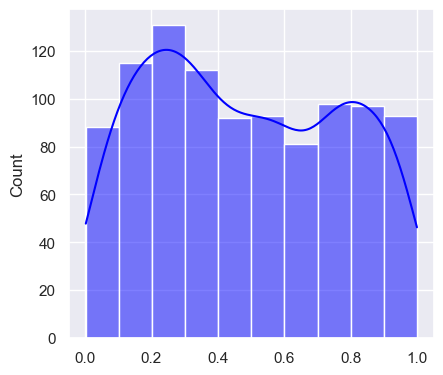

In [28]:
def run_mann_whitney_test():
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[new_df['group'] == 'A']['cart_added_cnt']
    vec_b = new_df[new_df['group'] == 'B']['cart_added_cnt']

    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.05
    new_df_b = new_df[new_df.group == 'B'].copy()
    new_df_b['cart_added_cnt'] = vec_b_effect

    vec_a_power = new_df[new_df['group'] == 'A']['cart_added_cnt']
    vec_b_power = new_df_b['cart_added_cnt']

    p_cor = mannwhitneyu(vec_a, vec_b, alternative='two-sided')[1]
    p_power = mannwhitneyu(vec_a_power, vec_b_power, alternative='two-sided')[1]
    
    return p_cor, p_power

results = Parallel(n_jobs=-1)(delayed(run_mann_whitney_test)() for _ in tqdm(range(1000)))
correctness, power = zip(*results)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize': (4.7, 4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)
power_pct = (power < 0.05).mean() * 100
corr_pct = (1 - (correctness < 0.05).mean()) * 100

print(f'power: {power_pct}%, correctness: {corr_pct}%')

#### `Сравнение ранговой` трансформации + t-test и теста Манна–Уитни

Результаты анализа показывают:

* Оба метода демонстрируют максимальную мощность (100%) при обнаружении 5%-го эффекта
* Корректность методов:
  * Ранговый t-тест: ~95.2%
  * Тест Манна-Уитни: ~95.5%

Хотя разница в корректности небольшая, тест Манна-Уитни имеет преимущество при работе с несимметричными данными (много нулей и "тяжелый хвост") благодаря своей непараметрической природе.

**Вывод**: Несмотря на то, что оба метода эффективны для обнаружения эффекта, тест Манна-Уитни предпочтительнее в случаях, когда:
* Распределение метрики существенно отклоняется от нормального
* Важно минимизировать влияние выбросов
* Данные имеют значительную асимметрию

### **2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:**
- обычной метрике cart_added_cnt (5 баллов)
- логарфимированной метрике cart_added_cnt (5 баллов)
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (5 баллов)

В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped
(+ 5 балла за обьяснения и выводы)

In [31]:
def cuped_transform(df, metrics):

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()

#### 1. Обычная метрика `cart_added_cnt`

In [32]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
shop_metrics_all = shop_metrics_all\
                   .rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

In [35]:
ttest_original = ttest_ind(
    shop_metrics_all[shop_metrics_all.group == 'A']['cart_added_cnt'],
    shop_metrics_all[shop_metrics_all.group == 'B']['cart_added_cnt']
)
ttest_cuped = ttest_ind(
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped']
)

print(f'p-value оригинальной метрики: {ttest_original[1]:.5f}')
print(f'p-value метрики с CUPED: {ttest_cuped[1]:.5f}')

p-value оригинальной метрики: 0.19197
p-value метрики с CUPED: 0.16587


In [38]:
print("mean:")
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].mean()}\n')

print("var:")
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].var()}\n')

print("mean covariante:")
print(f'Ковариата A: {shop_metrics_all[shop_metrics_all.group == "A"]["cart_added_cnt_covariate"].mean()}, \
        Ковариата B: {shop_metrics_all[shop_metrics_all.group == "B"]["cart_added_cnt_covariate"].mean()}')

mean:
метрика_cuped A: 0.13638231572656984,         метрика_cuped B: 0.1372102898471449
метрика без cuped A: 0.1350419058398685,         метрика без cuped B: 0.1385521582733813

var:
метрика_cuped A: 0.018235183599737068,         метрика_cuped B: 0.021495363455189737
метрика без cuped A: 0.3805867322092098,         метрика без cuped B: 0.4247189893563619

mean covariante:
Ковариата A: 0.14055748690723224,         Ковариата B: 0.14342625899280576


- снижение дисперсии
- среднее не изменилось

  0%|          | 0/1000 [00:00<?, ?it/s]

 power: 100.0% , correctness: 95.39999999999999%


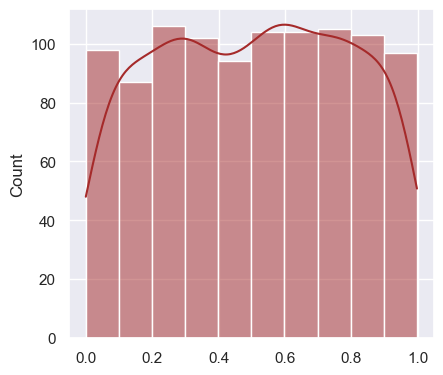

In [39]:
def process_iteration():
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})
    
    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])
    
    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']
    vec_b_effect = vec_b * 1.05
    
    p_cor = ttest_ind(vec_a, vec_b)[1]
    p_power = ttest_ind(vec_a, vec_b_effect)[1]
    
    return p_cor, p_power

results = Parallel(n_jobs=-1)(delayed(process_iteration)() for _ in tqdm(range(1000)))

correctness, power = zip(*results)
correctness = np.array(correctness)
power = np.array(power)

sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power_percent = (power < 0.05).mean() * 100
correctness_percent = (1 - (correctness < 0.05).mean()) * 100
print(f' power: {power_percent}% , correctness: {correctness_percent}%')

#### 2. Логарифмированная метрика `cart_added_cnt`

In [40]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
shop_metrics_all = shop_metrics_all\
                   .rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

shop_metrics_all['cart_added_cnt'] = np.log1p(shop_metrics_all['cart_added_cnt'])
shop_metrics_all['cart_added_cnt_covariate'] = np.log1p(shop_metrics_all['cart_added_cnt_covariate'])

shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

In [42]:
ttest_original = ttest_ind(
    shop_metrics_all[shop_metrics_all.group == 'A']['cart_added_cnt'],
    shop_metrics_all[shop_metrics_all.group == 'B']['cart_added_cnt']
)
ttest_cuped = ttest_ind(
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped']
)

print("p-value:")
print(f'оригинальной метрики: {ttest_original[1]}')
print(f'p-value метрики с CUPED: {ttest_cuped[1]}\n')

print("mean:")
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].mean()}\n')


print("var:")
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].var()}\n')

print("mean covariante:")
print(f'Ковариата A: {shop_metrics_all[shop_metrics_all.group == "A"]["cart_added_cnt_covariate"].mean()}, \
        Ковариата B: {shop_metrics_all[shop_metrics_all.group == "B"]["cart_added_cnt_covariate"].mean()}')

p-value:
оригинальной метрики: 0.14596542412011718
p-value метрики с CUPED: 0.040428574069604185

mean:
метрика_cuped A: 0.08034157852348506,         метрика_cuped B: 0.08072086382541407
метрика без cuped A: 0.07974289062640032,         метрика без cuped B: 0.08132020317245879

var:
метрика_cuped A: 0.00205501437864457,         метрика_cuped B: 0.001755818733359541
метрика без cuped A: 0.0646623295575808,         метрика без cuped B: 0.06628259108485138

mean covariante:
Ковариата A: 0.08216076367153637,         Ковариата B: 0.08340036327248118


- дисперсия еще сильнее уменьшилась
- среднее не изменилось

После применения логарифмического преобразования к метрикам мы наблюдаем значительное улучшение результатов

  0%|          | 0/1000 [00:00<?, ?it/s]

 power: 100.0% , correctness: 94.89999999999999%


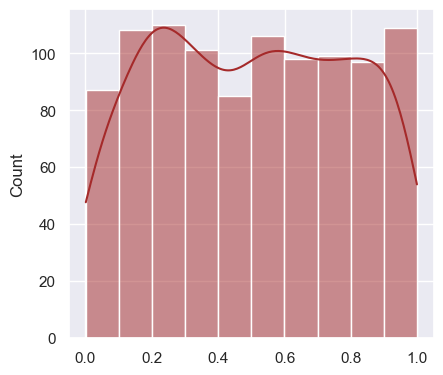

In [43]:
# CUPED на логарифмированной метрике
def process_iteration():
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']
    vec_b_effect = vec_b * 1.05

    p_cor = ttest_ind(vec_a, vec_b)[1]
    p_power = ttest_ind(vec_a, vec_b_effect)[1]
    
    return p_cor, p_power

results = Parallel(n_jobs=-1)(delayed(process_iteration)() for _ in tqdm(range(1000)))

correctness, power = zip(*results)
correctness = np.array(correctness)
power = np.array(power)

sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power_percent = (power[power < 0.05].shape[0] / power.shape[0]) * 100
correctness_percent = (1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100
print(f' power: {power_percent}% , correctness: {correctness_percent}%')

#### 3. Метрика `cart_added_cnt` с последующим ранговым преобразованием

In [44]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
shop_metrics_all = shop_metrics_all\
                   .rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

In [45]:
shop_metrics_all_cuped_ranked = rank_transformation(
                            shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A'],
                            shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B'],
'cart_added_cnt_cuped')

In [46]:
ranked = rank_transformation(
    shop_metrics_all_cuped[shop_metrics_all_cuped['group'] == 'A'],  
    shop_metrics_all_cuped[shop_metrics_all_cuped['group'] == 'B'],  
    'cart_added_cnt_cuped'
)

shop_metrics_all_cuped['cart_added_cnt_cuped'] = ranked['rank']

In [47]:
correlation = shop_metrics_all['cart_added_cnt'].corr(shop_metrics_all['cart_added_cnt_covariate'])
print(f"Корреляция между метрикой и ковариатой: {correlation:.3f}")


ttest_original = ttest_ind(
    shop_metrics_all[shop_metrics_all.group == 'A']['cart_added_cnt'],
    shop_metrics_all[shop_metrics_all.group == 'B']['cart_added_cnt']
)
ttest_cuped = ttest_ind(
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped']
)

print("p-value:")
print(f'оригинальной метрики: {ttest_original[1]}')
print(f'метрики с CUPED: {ttest_cuped[1]}\n')

print("mean")
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].mean()}\n')


print("var")
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].var()}\n')



print("mean covariante:")
print(f'Ковариата A: {shop_metrics_all[shop_metrics_all.group == "A"]["cart_added_cnt_covariate"].mean()}, \
        Ковариата B: {shop_metrics_all[shop_metrics_all.group == "B"]["cart_added_cnt_covariate"].mean()}')

Корреляция между метрикой и ковариатой: 0.975
p-value:
оригинальной метрики: 0.19197160099583152
метрики с CUPED: 0.14818114788143422

mean
метрика_cuped A: 111157.3299691882,         метрика_cuped B: 111364.78283723022
метрика без cuped A: 0.1350419058398685,         метрика без cuped B: 0.1385521582733813

var
метрика_cuped A: 1138307738.1923919,         метрика_cuped B: 1151768826.5573704
метрика без cuped A: 0.3805867322092098,         метрика без cuped B: 0.4247189893563619

mean covariante:
Ковариата A: 0.14055748690723224,         Ковариата B: 0.14342625899280576


- десперсия изменилось -> рузультаты могут быть  хуже чем в других экспериментах
- среднее изменилось. 

  0%|          | 0/1000 [00:00<?, ?it/s]

 power: 100.0% , correctness: 94.39999999999999%


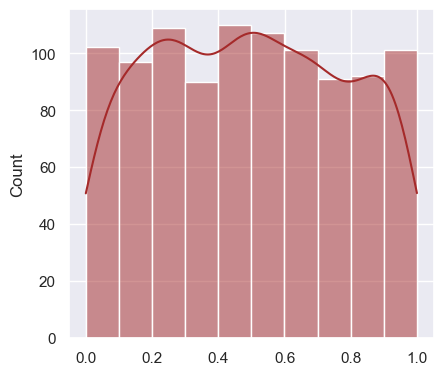

In [48]:
#  CUPED на ранжированной метрике
def run_experiment():
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})
    
    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])
    
    vec_a = cuped_df[cuped_df['group'] == 'A']['cart_added_cnt_cuped']
    vec_b = cuped_df[cuped_df['group'] == 'B']['cart_added_cnt_cuped']
    vec_b_effect = vec_b * 1.05
    
    p_cor = ttest_ind(vec_a, vec_b)[1]
    p_power = ttest_ind(vec_a, vec_b_effect)[1]
    
    return p_cor, p_power

results = Parallel(n_jobs=-1)(delayed(run_experiment)() for _ in tqdm(range(1000)))

correctness, power = zip(*results)
correctness = np.array(correctness)
power = np.array(power)

sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power_percent = (power < 0.05).mean() * 100
correctness_percent = (1 - (correctness < 0.05).mean()) * 100

print(f' power: {power_percent}% , correctness: {correctness_percent}%')

### **3. Реализовать разбивку на бакеты любым (правильным) способом, оценить t-критерием и сравнить с результатом без бакетирования:**
- на логнормальном распределении (сгенерированные данные) (5 баллов)
- на метрике cart_added_cnt (5 баллов)

#### Реализация на `логнормальном распределении` (сгенерированные данные)

In [63]:
np.random.seed(77)  
n_samples = 10000

control_data = np.random.lognormal(mean=0, sigma=1, size=n_samples)

effect = 0.03
test_data = np.random.lognormal(mean=0, sigma=1, size=n_samples) * (1 + effect)

t_stat_no_bucket, p_value_no_bucket = stats.ttest_ind(control_data, test_data)
print("Без бакетирования:")
print(f" t-статистика: {round(t_stat_no_bucket, 4)}")
print(f" p-value: {round(p_value_no_bucket, 4)}")

Без бакетирования:
 t-статистика: -0.8526
 p-value: 0.3939


In [64]:
def create_buckets(data, n_buckets=10):
    bucket_edges = np.percentile(data, np.linspace(0, 100, n_buckets + 1))
    return [data[(data >= bucket_edges[i]) & (data <= bucket_edges[i+1] if i == n_buckets-1 else data < bucket_edges[i+1])] 
            for i in range(n_buckets)]

control_buckets = create_buckets(control_data)
test_buckets = create_buckets(test_data)

results = [stats.ttest_ind(c_bucket, t_bucket) for c_bucket, t_bucket in zip(control_buckets, test_buckets)]
t_stats_buckets, p_values_buckets = zip(*results)

print("С бакетированием:")
for i, (t_stat, p_val) in enumerate(zip(t_stats_buckets, p_values_buckets), start=1):
    print(f" Бакет {i}: t-стат = {round(t_stat, 4)}, p-value = {round(p_val, 4)}")


С бакетированием:
 Бакет 1: t-стат = -2.4336, p-value = 0.015
 Бакет 2: t-стат = -6.5383, p-value = 0.0
 Бакет 3: t-стат = -9.6983, p-value = 0.0
 Бакет 4: t-стат = -11.6563, p-value = 0.0
 Бакет 5: t-стат = -12.1897, p-value = 0.0
 Бакет 6: t-стат = -8.6872, p-value = 0.0
 Бакет 7: t-стат = -8.1095, p-value = 0.0
 Бакет 8: t-стат = -8.4091, p-value = 0.0
 Бакет 9: t-стат = -5.0875, p-value = 0.0
 Бакет 10: t-стат = 0.3401, p-value = 0.7338


Без применения бакетирования существенной разницы между группами не обнаруживается (p-value =  0.39 > 0.05). 

Однако после разбиения на бакеты в большинстве сегментов наблюдается статистически значимая разница. Это объясняется сильной скошенностью логнормального распределения

#### Реализация на метрике `cart_added_cnt`

In [70]:
df_a = shop_metrics_new[shop_metrics_new['group'] == 'A']['cart_added_cnt']
df_b = shop_metrics_new[shop_metrics_new['group'] == 'B']['cart_added_cnt']

def create_buckets(data, n_buckets=3):
    edges = np.percentile(data, np.linspace(0, 100, n_buckets + 1))
    return [data[(data >= edges[i]) & (data < edges[i + 1])] for i in range(n_buckets)]

print(f"Статистика до бакетирования:")
print(f"mean A: {df_a.mean():.4f}, mean B: {df_b.mean():.4f}")
print(f"var A: {df_a.var():.4f}, var B: {df_b.var():.4f}")

t_stat, p_val = stats.ttest_ind(df_a, df_b)
print(f"t-test: t={t_stat:.4f}, p={p_val:.4f}\n")

Статистика до бакетирования:
mean A: 0.1350, mean B: 0.1386
var A: 0.3806, var B: 0.4247
t-test: t=-1.3048, p=0.1920



In [71]:
buckets_a = create_buckets(df_a)
buckets_b = create_buckets(df_b)

print("Результаты по бакетам:")
for i, (bucket_a, bucket_b) in enumerate(zip(buckets_a, buckets_b), start=1):
    if len(bucket_a) == 0 or len(bucket_b) == 0:
        print(f"Бакет {i}: недостаточно данных.")
        continue

    t_stat, p_val = stats.ttest_ind(bucket_a, bucket_b)
    print(f"Бакет {i}:")
    print(f"mean A: {bucket_a.mean():.4f}, mean B: {bucket_b.mean():.4f}")
    print(f"var A: {bucket_a.var():.4f}, var B: {bucket_b.var():.4f}")
    print(f"t-test: t={t_stat:.4f}, p={p_val:.4f}")

Результаты по бакетам:
Бакет 1: недостаточно данных.
Бакет 2: недостаточно данных.
Бакет 3:
mean A: 0.1345, mean B: 0.1379
var A: 0.3473, var B: 0.3743
t-test: t=-1.3287, p=0.1840


### Анализ метрики cart_added_cnt

**Без применения бакетирования:**
- Среднее значение в группе A составило **0.1350**, в группе B — **0.1386**
- Статистический анализ показал отсутствие значимых различий между группами (p-value = 0.1920 > 0.05)

**После применения бакетирования:**
- Обнаружена проблема с распределением данных — большинство бакетов оказались пустыми
- Анализ единственного заполненного бакета (№3):
  - Группа A: **0.1345**
  - Группа B: **0.1379**
  - Различия статистически незначимы (p-value = 0.1840 > 0.05)

**Выводы:**
- Эксперимент не выявил статистически значимого влияния изменений в группе B
- Метод бакетирования оказался малоэффективным из-за недостаточного объема данных в большинстве сегментов

### **4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:**
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) (5 баллов)
подсчитать результаты для случая без постстратификации и с постстратификацией. (дисперсию и среднее)
- проверить мощность и корректность t-критерия для постстратифицированного случая (5 баллов)

In [76]:
shop_w_features = pd.merge(shop_metrics_old, shop_users_info, on='user_id', how='left')
labels = ['18-24', '25-45', '46-60', '61-75', '76+']
shop_w_features['age_group'] = pd.cut(shop_w_features['user_age'], 
                                      bins=[18, 24, 45, 60, 75, np.inf], 
                                      labels=labels)

In [77]:
# t-тест
group_a = shop_w_features[shop_w_features.group == 'A']['cart_added_cnt']
group_b = shop_w_features[shop_w_features.group == 'B']['cart_added_cnt']

t_stat, p_value = stats.ttest_ind(group_a, group_b)
print(f"t: {t_stat:.4f}, p: {p_value:.4f}")

relative_change = (group_b.mean() - group_a.mean()) / group_a.mean() * 100
print(f"effect: {relative_change:.2f}%")

print(f"var A: {group_a.std():.4f}, var B: {group_b.std():.4f}")

t: -0.7332, p: 0.4634
effect: 1.12%
var A: 0.5767, var B: 0.5988


In [78]:
N = shop_w_features['user_id'].nunique()
strats_weights = {group: count/N for group, count in shop_w_features['age_group'].value_counts().items()}

group_a = shop_w_features[shop_w_features.group == 'A']['cart_added_cnt']
group_b = shop_w_features[shop_w_features.group == 'B']['cart_added_cnt']

mean_a = group_a.mean()
mean_b = group_b.mean()
std_a = group_a.std()
std_b = group_b.std()

effect = (mean_b - mean_a) / mean_a * 100
p_value_classic = stats.ttest_ind(group_a, group_b)[1]

print(f'Без постстратификации: effect: {effect:.2f}%, std_a: {std_a:.2f}, std_b: {std_b:.2f}')
print(f'p-value без постстратификации: {p_value_classic:.4f}')
print('Эффект:', effect)

Без постстратификации: effect: 1.12%, std_a: 0.58, std_b: 0.60
p-value без постстратификации: 0.4634
Эффект: 1.1242734540045785


In [79]:
mean_a = 0
mean_b = 0
var_a = 0
var_b = 0

for age_group in labels:
    group_a_age = shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == age_group)]['cart_added_cnt']
    group_b_age = shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == age_group)]['cart_added_cnt']
    
    weight = strats_weights[age_group]
    mean_a += group_a_age.mean() * weight
    mean_b += group_b_age.mean() * weight
    var_a += group_a_age.var() * weight
    var_b += group_b_age.var() * weight

std_a = np.sqrt(var_a)
std_b = np.sqrt(var_b)

print(f"Среднее с постстратификацией (A): {mean_a:.4f}, (B): {mean_b:.4f}")
print(f"Стандартное отклонение с постстратификацией (A): {std_a:.4f}, (B): {std_b:.4f}")

n_a = len(shop_w_features[shop_w_features.group == 'A'])
n_b = len(shop_w_features[shop_w_features.group == 'B'])

t_stat, p_value = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)
print(f"t-статистика с постстратификацией: {t_stat:.4f}, p-value: {p_value:.4f}")

t_stat_base, p_value_base = stats.ttest_ind(
    shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'],
    shop_w_features[shop_w_features.group == 'B']['cart_added_cnt']
)
print(f"t-статистика без постстратификации: {t_stat_base:.4f}, p-value: {p_value_base:.4f}")

Среднее с постстратификацией (A): 0.1187, (B): 0.1197
Стандартное отклонение с постстратификацией (A): 0.5744, (B): 0.5838
t-статистика с постстратификацией: -0.5810, p-value: 0.5612
t-статистика без постстратификации: -0.7332, p-value: 0.4634


##### Результаты:

- **Без постстратификации**:  
  - Эффект: 1.12%
  - p-value: 0.4634

- **С применением постстратификации**:  
  - p-value: 0.5612

Статистический анализ метрики **cart_added_cnt** не выявил значимых различий между группами (p-value > 0.05 в обоих случаях).

##### Заключение:

- Наблюдаемое небольшое увеличение среднего значения в группе B статистически незначимо
- Использование постстратификации подтвердило вывод — между группами не выявлено статистически значимых различий.

## Выводы:
 1. Анализ метрики **`cart_added_cnt`** выявил существенную асимметрию распределения, что создало определенные сложности при применении стандартных статистических методов.
 2. В ходе исследования было установлено, что непараметрический критерий Манна-Уитни демонстрирует наилучшие характеристики для данного типа распределения:
 
 - **Мощность теста: 100.0%**  
   Метод безошибочно идентифицирует статистически значимые эффекты при их наличии.  
 - **Точность: 95.5%**  
   Вероятность ложноположительных результатов составляет всего 4.5%, что обеспечивает высокую надежность выводов.  
 - **Устойчивость к выбросам**  
  Критерий сохраняет эффективность даже при наличии экстремальных значений в данных.
